# Stacked Bidirectional LSTM Sentiment Classifier

In this notebook, we *stack* LSTM layers to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM, Bidirectional # Import Bidirectional directly from keras.layers
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/stackedLSTM'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 10000
max_review_length = 200
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# LSTM layer architecture:
n_lstm_1 = 64 # lower
n_lstm_2 = 64 # new!
drop_lstm = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm,
                             return_sequences=True)))
model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [6]:
# LSTM layer parameters double due to both reading directions
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras") # Changed the file extension to .keras
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6566 - loss: 0.5883 - val_accuracy: 0.8475 - val_loss: 0.3681
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8865 - loss: 0.2871 - val_accuracy: 0.8566 - val_loss: 0.3391
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9219 - loss: 0.2096 - val_accuracy: 0.8506 - val_loss: 0.3425
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9248 - loss: 0.2054 - val_accuracy: 0.8646 - val_loss: 0.3551


#### Evaluate

In [11]:
model.load_weights(output_dir+"/weights.02.keras") # Changed the file extension to .keras to match the saved weights.

In [13]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step


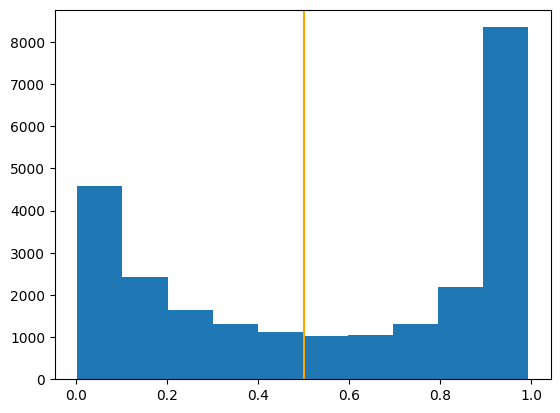

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.76'